In [338]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp

In [339]:
infection_df = pd.read_excel('raw_data.xlsx', sheet_name ="infection").drop(axis =1,columns=["编号"])
normal_df = pd.read_excel('raw_data.xlsx', sheet_name ="normal").drop(axis=1,columns=["编号"])

infection_df['CD45+(cells/ul)'].fillna(infection_df['CD45+(cells/ul)'].dropna().median(), inplace=True)
normal_df['CD45+(cells/ul)'].fillna(normal_df['CD45+(cells/ul)'].dropna().median(), inplace=True)

In [340]:
infection_df["label"] = 1
normal_df["label"] = 0

In [341]:
data_df = pd.concat([infection_df, normal_df])
data_df["CD4/CD8"] = data_df["CD4+T(cells/ul)"]/data_df["CD8+T(cells/ul)"]
data_df["SEX(0M1F)"][data_df["SEX(0M1F)"]==0] = -1

C:\Users\H\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [342]:
data_df["SEX(0M1F)"].fillna(data_df['SEX(0M1F)'].dropna().median(), inplace=True)
data_df = data_df.reset_index().drop(axis =1,columns=["index"])

In [343]:
data_df_norm = (data_df - data_df.mean()) / (data_df.max() - data_df.min())

In [344]:
data_df_norm["SEX(0M1F)"][data_df_norm["SEX(0M1F)"]>0]=1
data_df_norm["SEX(0M1F)"][data_df_norm["SEX(0M1F)"]<0]=-1
data_df_norm["label"][data_df_norm["label"]>0]=1
data_df_norm["label"][data_df_norm["label"]<0]=0

In [345]:
data_df_norm["label"] = data_df_norm["label"].astype("int")

In [346]:
X = data_df_norm.drop(axis =1,columns=["label"])
y = data_df_norm["label"]
n_samples, n_features = X.shape
print(X.shape)

(129, 16)


In [347]:
def draw_cross_roc(X,y,classifier, n_splits=5):
    # #############################################################################
    # Classification and ROC analysis

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X.loc[train], y[train]).predict_proba(X.loc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

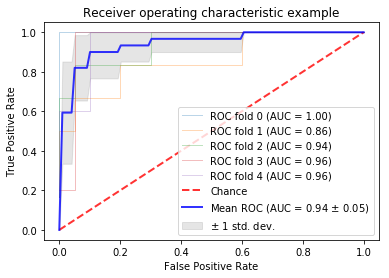

In [348]:
classifier = SVC(kernel='linear', probability=True,
                         random_state=random_state)
draw_cross_roc(X,y, classifier)

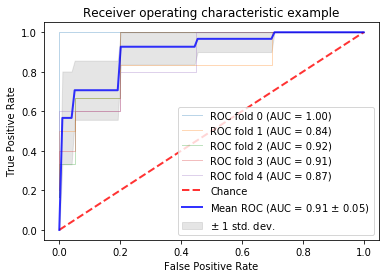

In [349]:
draw_cross_roc(X,y,LogisticRegression())

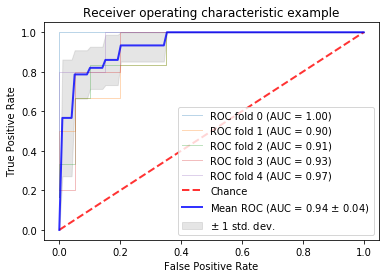

In [375]:
draw_cross_roc(X,y,MLPClassifier(hidden_layer_sizes=(5, ), max_iter=2000))

In [370]:
def plot_coefficients(classifier, feature_names):
    coef = classifier.coef_.ravel()
    sorted_coefficients = np.argsort(coef)
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[sorted_coefficients]]
    plt.bar(np.arange(len(sorted_coefficients)), coef[sorted_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, len(sorted_coefficients)), feature_names[sorted_coefficients], rotation=60, ha='right')
    plt.show()

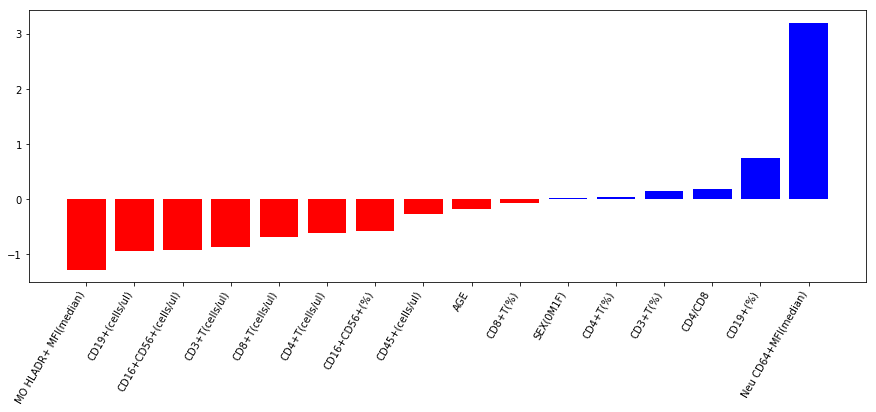

In [371]:
plot_coefficients(classifier, data_df.drop(axis =1,columns=["label"]).columns.values)